In [288]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from enum import Enum
import scipy.stats
import matplotlib.cm as cm
from omnetpp.scave import results, chart, utils

class StatType(Enum):
    SCALAR = "count"
    VECTOR = "vector"

In [289]:
mpl.rcParams['figure.dpi'] = 100
relPath = "../"

DEBUG = True

simName = "Wired"

rep = 20
simTimeLimit = 100
numCliG1 = 3
numCliG2 = 3

In [290]:
fileNamesSca = []
fileNamesVec = []

cliMeasNames = [("packetReceived", StatType.SCALAR), ("endToEndDelay", StatType.VECTOR), ("throughput", StatType.VECTOR)]

for i in range(0,rep):
    fileNamesSca.append(relPath + simName + '-#' + i.__str__() + '.sca')
    fileNamesVec.append(relPath + simName + '-#' + i.__str__() + '.vec')
    

if DEBUG:
    print(fileNamesSca)
    print(fileNamesVec)

['../Wired-#0.sca', '../Wired-#1.sca', '../Wired-#2.sca', '../Wired-#3.sca', '../Wired-#4.sca', '../Wired-#5.sca', '../Wired-#6.sca', '../Wired-#7.sca', '../Wired-#8.sca', '../Wired-#9.sca', '../Wired-#10.sca', '../Wired-#11.sca', '../Wired-#12.sca', '../Wired-#13.sca', '../Wired-#14.sca', '../Wired-#15.sca', '../Wired-#16.sca', '../Wired-#17.sca', '../Wired-#18.sca', '../Wired-#19.sca']
['../Wired-#0.vec', '../Wired-#1.vec', '../Wired-#2.vec', '../Wired-#3.vec', '../Wired-#4.vec', '../Wired-#5.vec', '../Wired-#6.vec', '../Wired-#7.vec', '../Wired-#8.vec', '../Wired-#9.vec', '../Wired-#10.vec', '../Wired-#11.vec', '../Wired-#12.vec', '../Wired-#13.vec', '../Wired-#14.vec', '../Wired-#15.vec', '../Wired-#16.vec', '../Wired-#17.vec', '../Wired-#18.vec', '../Wired-#19.vec']


In [291]:
def createFilter(measNames):
    filter = ""##"type =~ \"scalar\" AND ("
    for i in range(len(measNames)):
        if i != len(measNames)-1:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\" OR "
        else:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\""##)"
    return filter

In [292]:
dataSca = results.read_result_files(fileNamesSca, filter_expression=createFilter(cliMeasNames))
dataVec = results.read_result_files(fileNamesVec, filter_expression=createFilter(cliMeasNames))
vec = results.get_vectors(dataVec)
scl = results.get_scalars(dataSca)

if DEBUG:
    print(createFilter(cliMeasNames))
    scl.to_csv("./outSC.csv", mode="w", header=True)
    vec.to_csv("./outVC.csv", mode="w", header=True)

name =~ "*packetReceived:count" OR name =~ "*endToEndDelay:vector" OR name =~ "*throughput:vector"


In [293]:
def plotBoxWiskerSca(measNames, numClients, cliGroup, title = "", xLab = "", yLab = "", cli = "client"): 
    plt.rcParams.update({'font.size': 12})   
    outVec = list()
    for j in range(cliGroup):
        for i in range(numClients):
            box = pd.DataFrame()
            for meas in measNames:
                strElem = ""
                if cli == "client":
                    strElem =  f"cliG{j+1}[{i}].app[0]"
                
                if meas[1] == StatType.SCALAR:
                    flt = scl[scl["name"].str.contains(meas[0] + ":" + meas[1].value)]
                    flt = flt[flt["module"].str.endswith(strElem)]
                    box[meas[0]] = flt["value"].reset_index(drop=True)
                 
            box = box.replace(np.nan, 0)
            outVec.append(box)
            if DEBUG:
                box.to_csv("./out.csv", mode="w", header=True)
            box.boxplot(grid=False, rot=90)
            plt.title(title + " (" + strElem + ")")
            plt.xlabel(xLab)
            plt.ylabel(yLab)
            plt.show()
    return outVec

In [294]:
def plotBoxWiskerVec(numClients, cliGroup, title = "", xLab = "", yLab = "", cli = "client", vecMeasName = "measureReceivedAmount", numRanges = 0):
    plt.rcParams["figure.figsize"] = (9,6)
    
    ranges = list()
    if numRanges != 0:
        incr = simTimeLimit/numRanges
        nxt = 0
        while nxt+incr <= 120:
            ranges.append((nxt, nxt + incr))
            nxt += incr
    if DEBUG:
        print(ranges)
    
    outVec = list()
    for j in range(cliGroup):
        for i in range(numClients):
            strElem = ""
            if cli == "client":
                strElem =  f"cliG{j+1}[{i}].app[0]"
            
            flt = vec[vec["name"].str.contains(vecMeasName + ":" + StatType.VECTOR.value)]
            flt = flt[flt["module"].str.endswith(strElem)]
            if numRanges == 0:   
                box = None
                rowNum = 0
                for row in flt.itertuples():
                    vecValue = pd.Series(row.vecvalue)
                    vecTime = pd.Series(row.vectime)
                    if box is None:
                        box = pd.DataFrame(columns=vecTime)
                    box.loc[rowNum] = vecValue.tolist()
                    rowNum += 1   
                                    
                box = box.replace(np.nan, 0)
                outVec.append(box)
                if DEBUG:
                    box.to_csv("./out.csv", mode="w", header=True)
                box.boxplot(grid=False, rot=90)
                plt.title(title + " (" + strElem + ")")
                plt.xlabel(xLab)
                plt.ylabel(yLab)
                plt.show()
            else:
                box = pd.DataFrame(columns=["value", "ranges"])
                rowNum = 0
                for row in flt.itertuples():
                    vecValue = pd.Series(row.vecvalue)
                    vecTime = pd.Series(row.vectime)
                    for val, time in zip(vecValue, vecTime):    
                        for rang in ranges:
                            if time > rang[0] and time <= rang[1]:
                                box.loc[rowNum] = list((val, rang))
                                rowNum += 1
                                break   
                                    
                outVec.append(box)
                if DEBUG:
                    box.to_csv("./out.csv", mode="w", header=True)
                box.boxplot(column="value", by="ranges", grid=False, rot=90)
                plt.suptitle('')
                plt.title(title + " (" + strElem + ")")
                plt.xlabel(xLab)
                plt.ylabel(yLab)
                plt.show()
                  
    return outVec

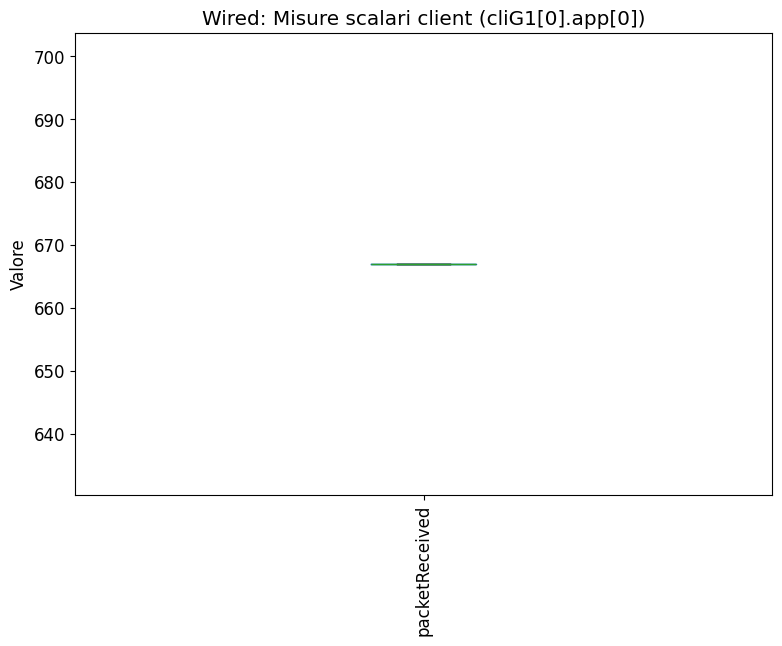

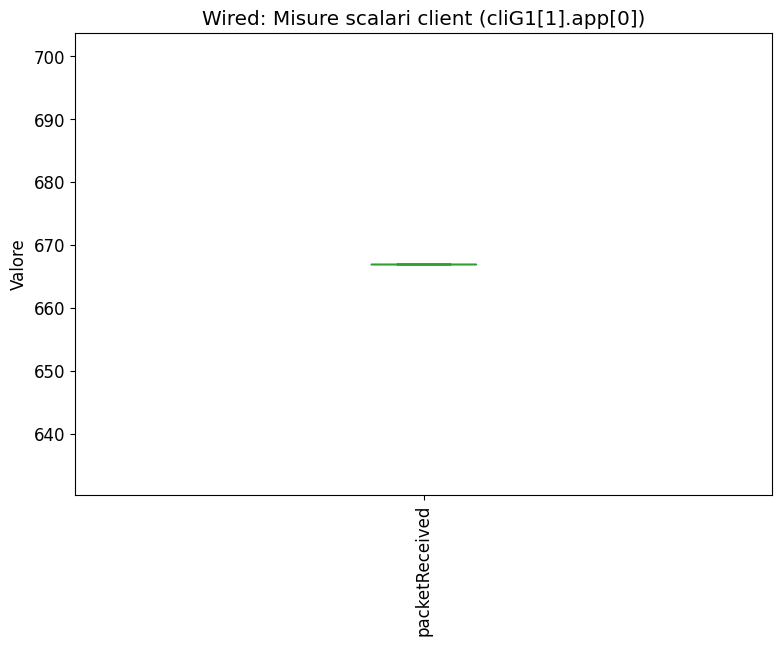

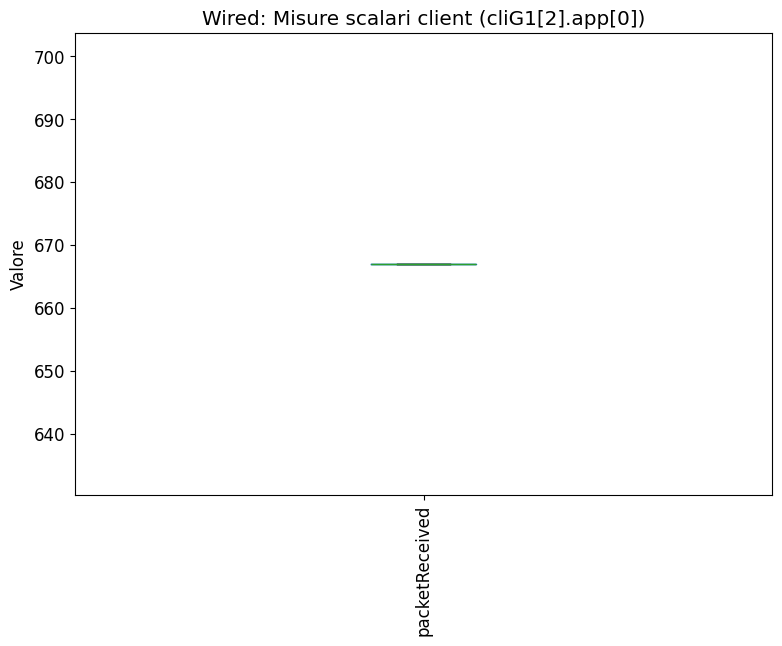

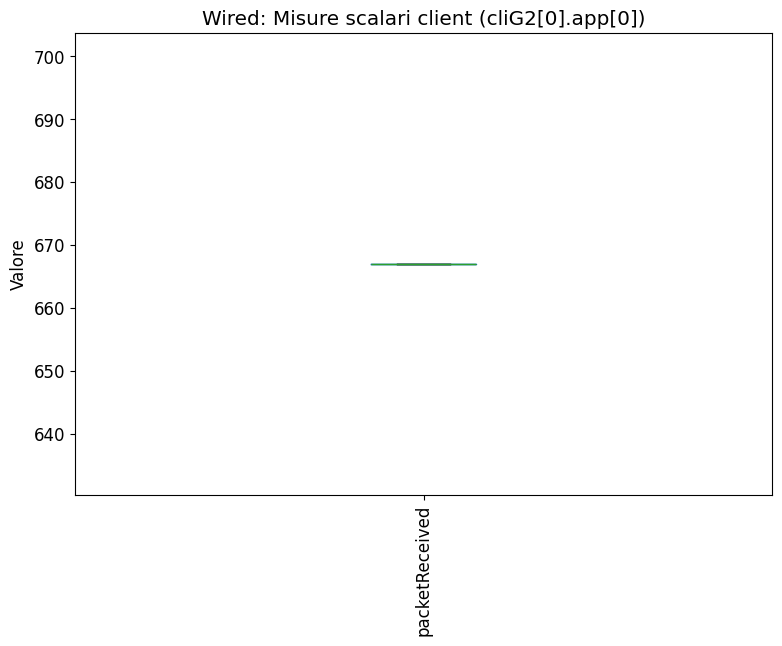

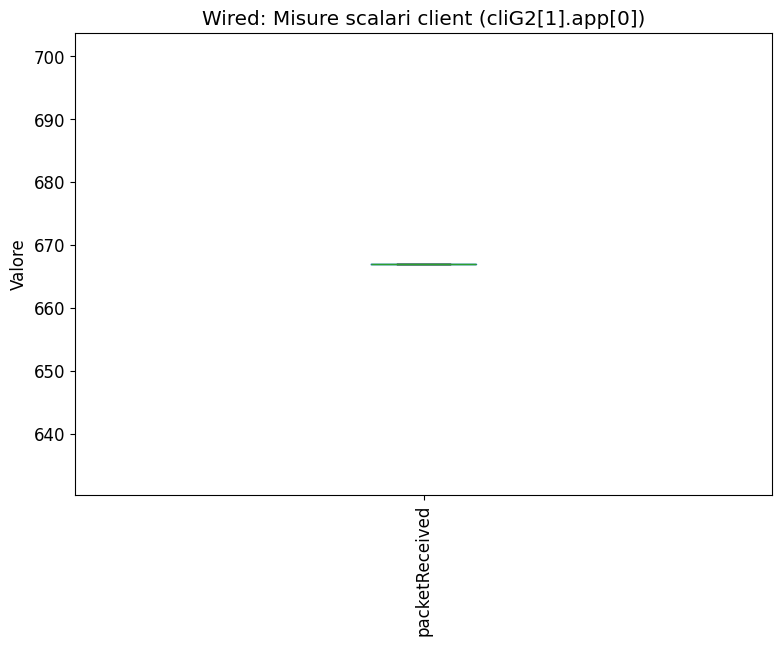

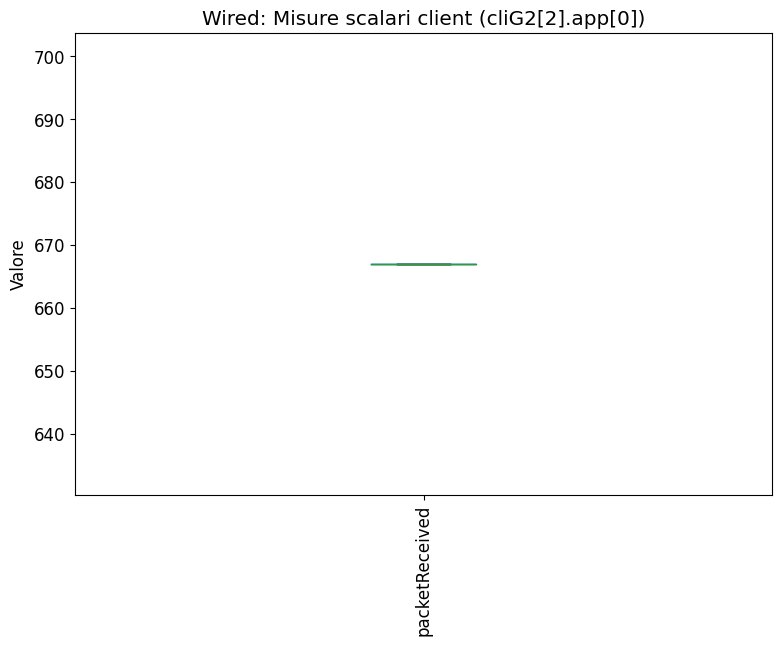

In [295]:
cliScaDfList = plotBoxWiskerSca(cliMeasNames, numCliG1, 2, title=simName + ": Misure scalari client", yLab="Valore")

[(0, 100.0)]


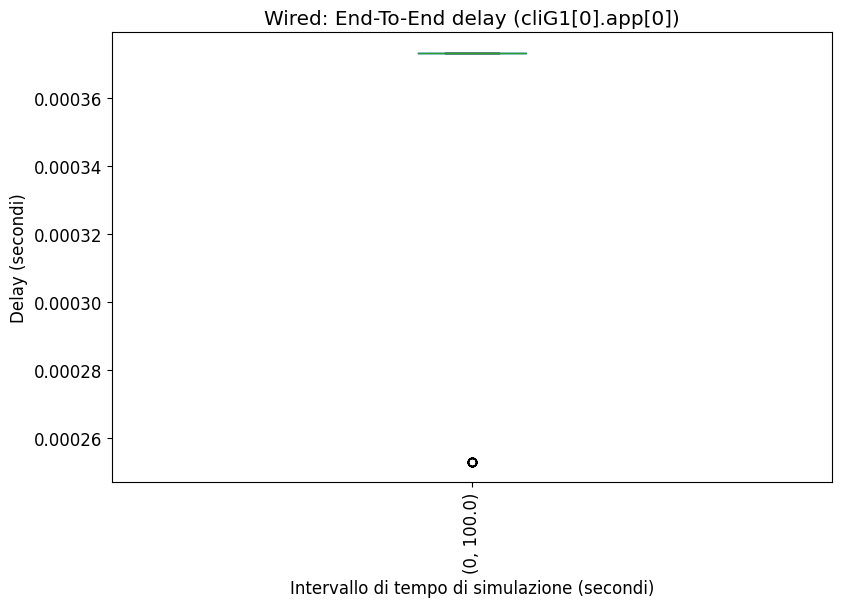

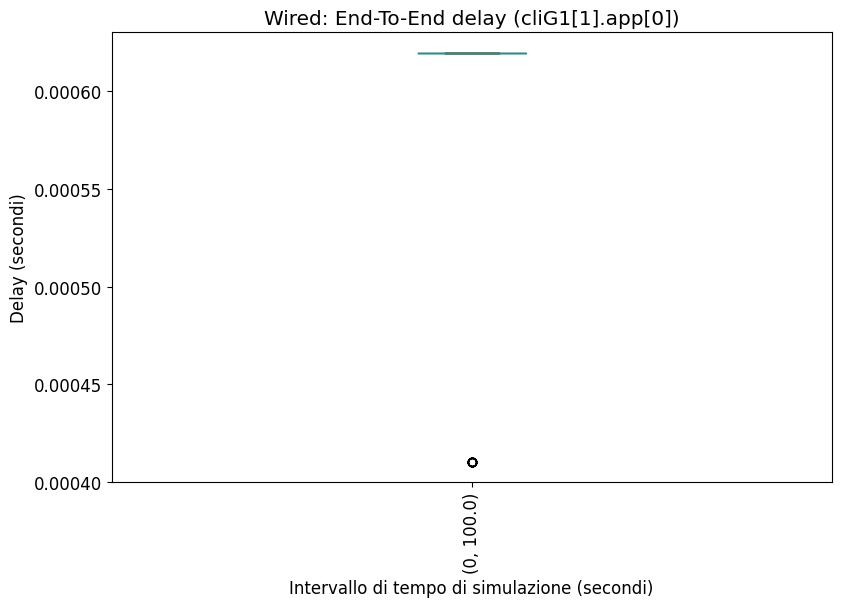

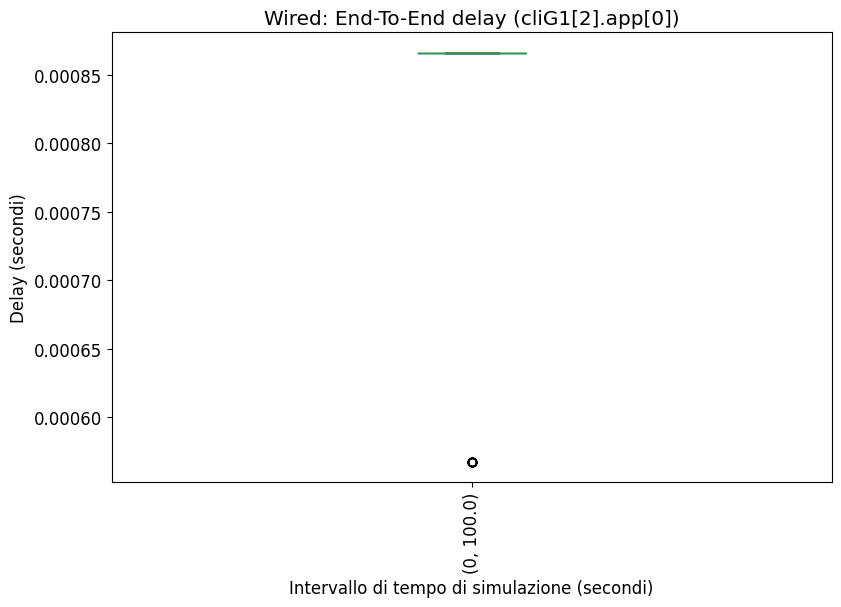

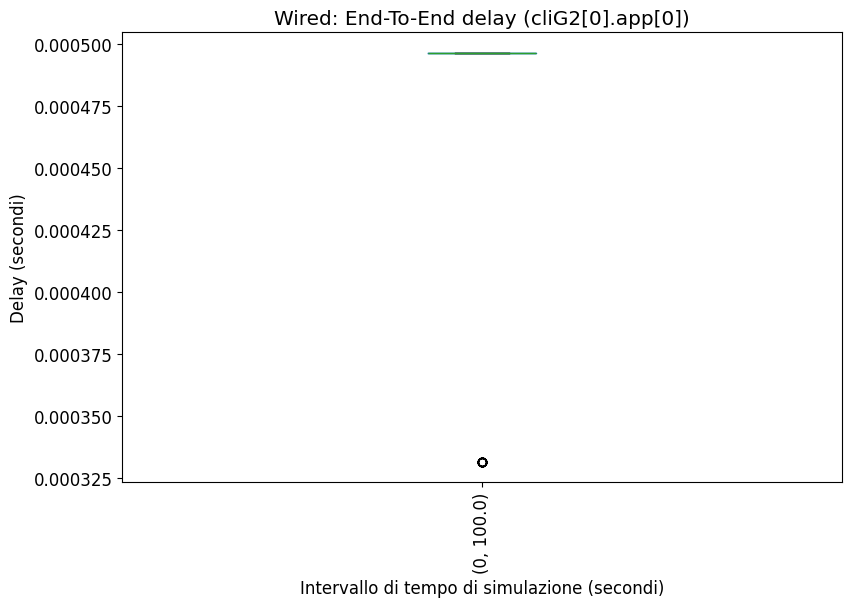

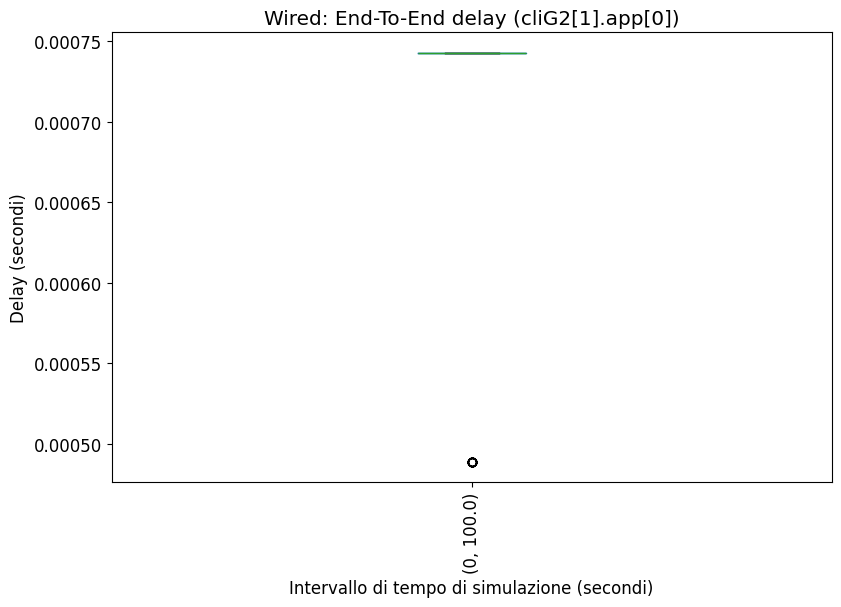

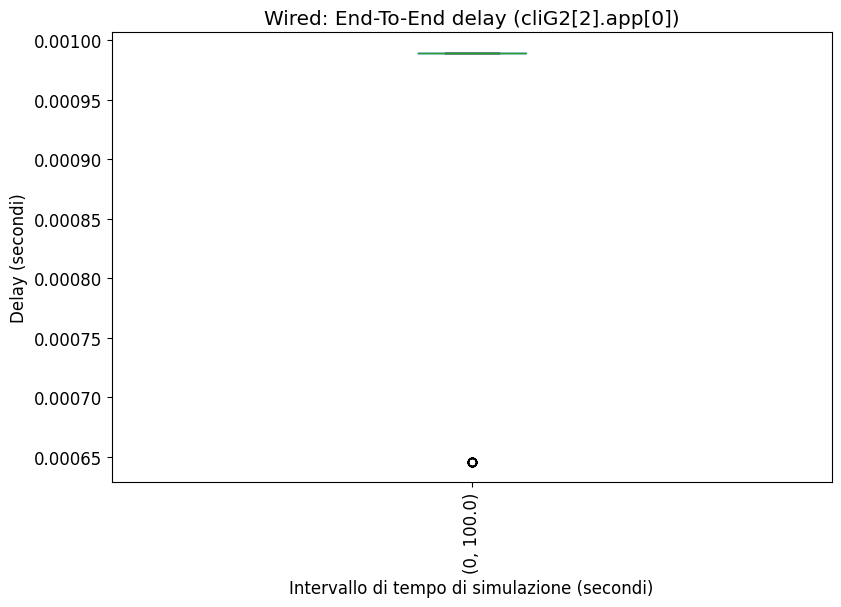

[(0, 10.0), (10.0, 20.0), (20.0, 30.0), (30.0, 40.0), (40.0, 50.0), (50.0, 60.0), (60.0, 70.0), (70.0, 80.0), (80.0, 90.0), (90.0, 100.0), (100.0, 110.0), (110.0, 120.0)]


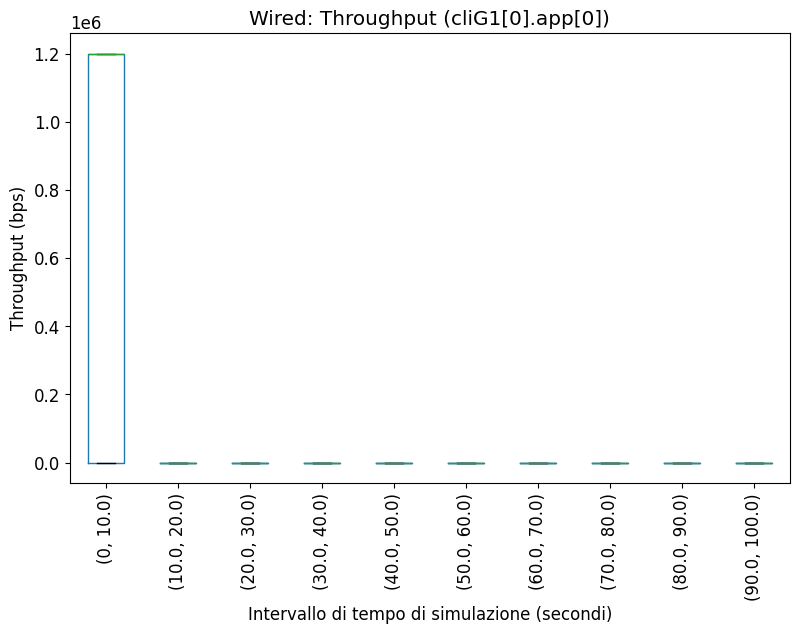

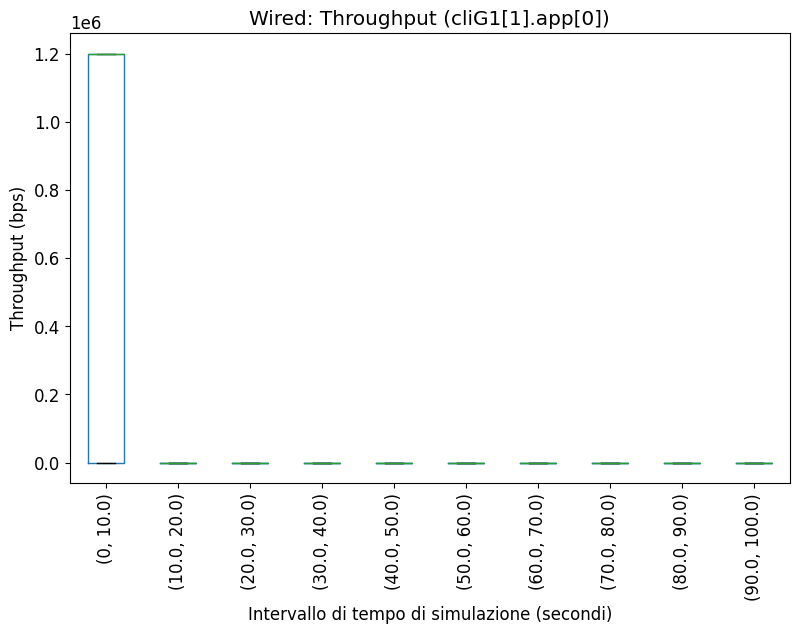

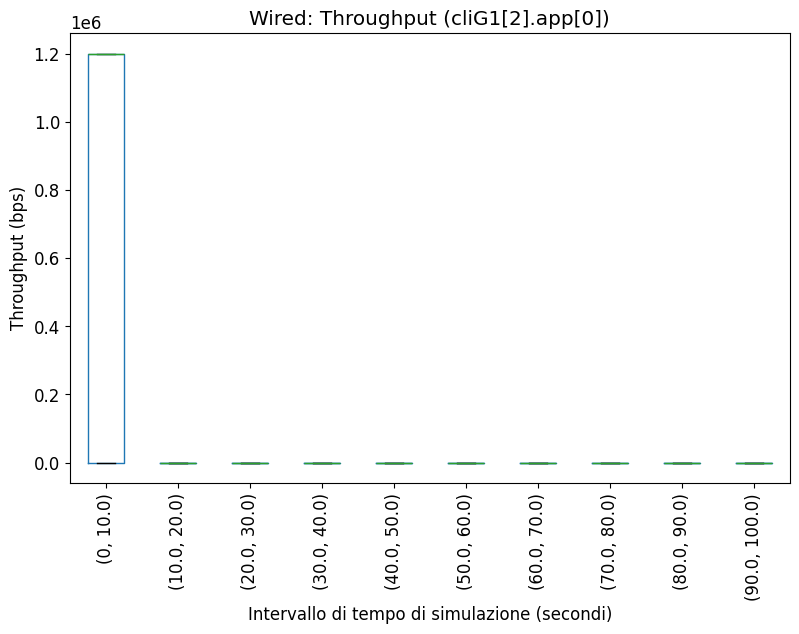

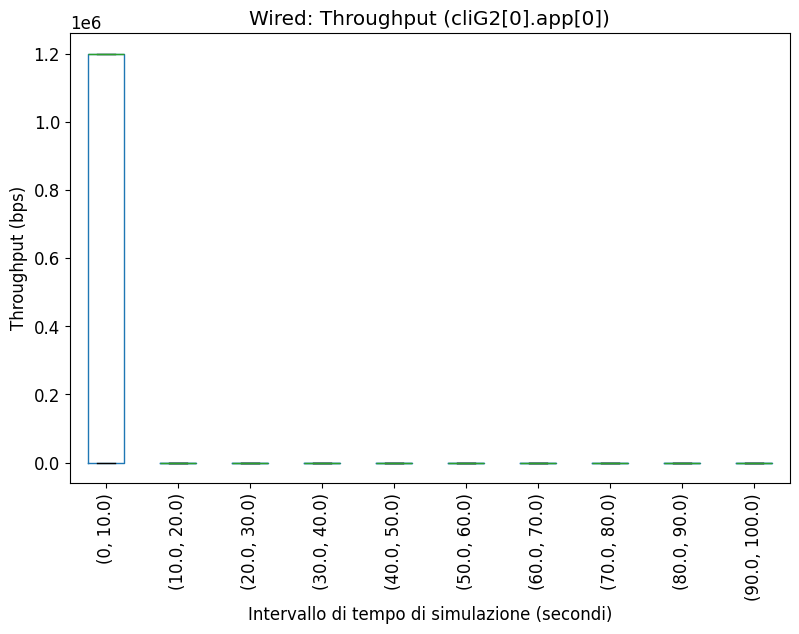

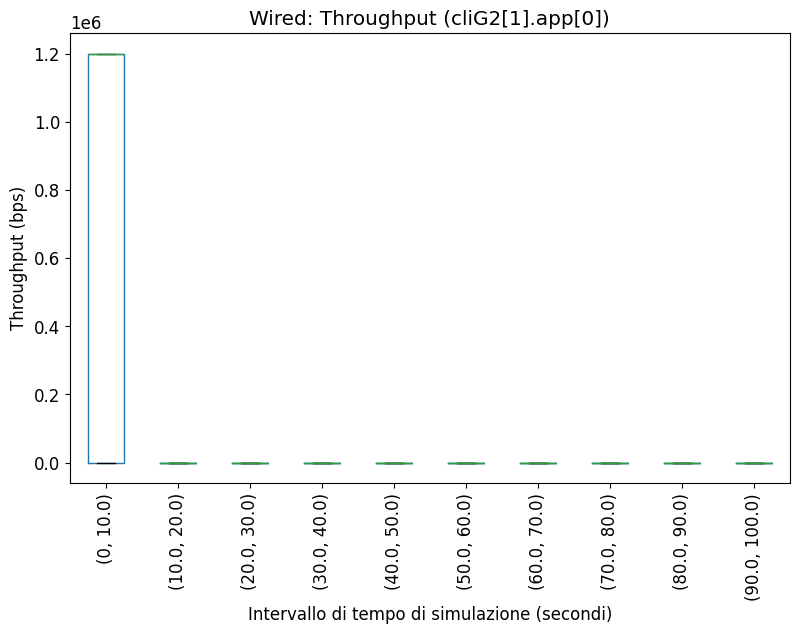

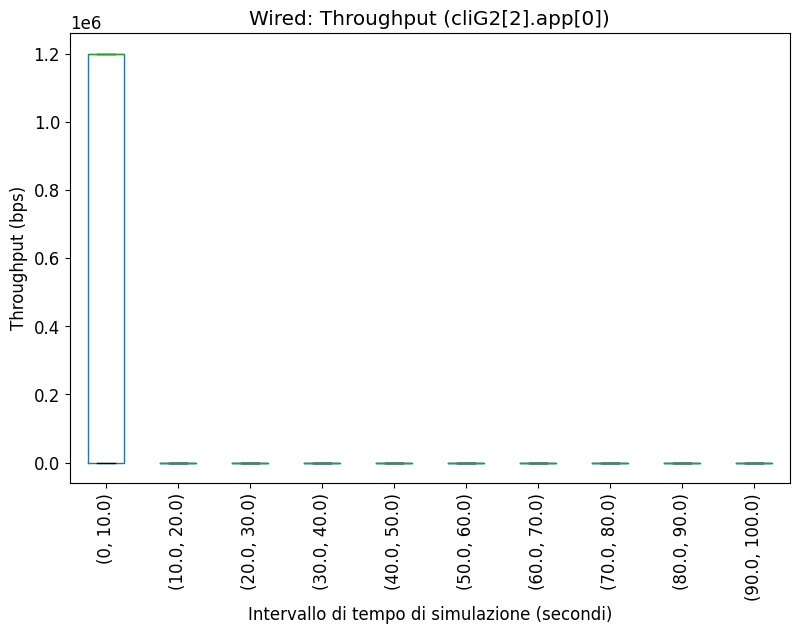

In [296]:
cliVecDfListEndToEnd = plotBoxWiskerVec(numCliG1, 2, title=simName + ": End-To-End delay", xLab = "Intervallo di tempo di simulazione (secondi)", yLab = "Delay (secondi)", vecMeasName="endToEndDelay", numRanges = 1)
cliVecDfListThr = plotBoxWiskerVec(numCliG1, 2, title=simName + ": Throughput", xLab = "Intervallo di tempo di simulazione (secondi)", yLab = "Throughput (bps)", vecMeasName="throughput", numRanges = 10)

In [297]:
def confidenceInterval(data, confidence = 0.95, altColName = None, decRound = 2):
    for (colName, colData) in data.items():
        a = 1.0 * np.array(colData.values)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * np.abs(scipy.stats.t.ppf((1-confidence)/2.0, n-1))
        relAcc = (h / m) * 100
        
        # m, m-h, m+h
        if(altColName != None):
            print("## Stat: " + altColName)
        else:
            print("## Stat: " + colName)
        print(f"Average: {round(m, decRound)}")
        print(f"Quantile: +-{round(h, decRound)}")
        print(f"Relative accuracy: {round(relAcc, decRound)} %")
        if DEBUG:   
            interval = scipy.stats.t.interval(confidence, df=n-1, loc=m, scale=se)
            print("Debug interval: " + str((interval[1] - interval[0])/2))

In [298]:
conf = 0.95
for j in range(2):
    for i in range(numCliG1):
        print("\n** " + simName + f": Confidence intervals for cliG{j+1}[{i}].app[0] at " + str(conf*100) + "%  **")
        confidenceInterval(cliScaDfList[(j+1)*i], conf)


** Wired: Confidence intervals for cliG1[0].app[0] at 95.0%  **
## Stat: packetReceived
Average: 667.0
Quantile: +-0.0
Relative accuracy: 0.0 %
Debug interval: nan

** Wired: Confidence intervals for cliG1[1].app[0] at 95.0%  **
## Stat: packetReceived
Average: 667.0
Quantile: +-0.0
Relative accuracy: 0.0 %
Debug interval: nan

** Wired: Confidence intervals for cliG1[2].app[0] at 95.0%  **
## Stat: packetReceived
Average: 667.0
Quantile: +-0.0
Relative accuracy: 0.0 %
Debug interval: nan

** Wired: Confidence intervals for cliG2[0].app[0] at 95.0%  **
## Stat: packetReceived
Average: 667.0
Quantile: +-0.0
Relative accuracy: 0.0 %
Debug interval: nan

** Wired: Confidence intervals for cliG2[1].app[0] at 95.0%  **
## Stat: packetReceived
Average: 667.0
Quantile: +-0.0
Relative accuracy: 0.0 %
Debug interval: nan

** Wired: Confidence intervals for cliG2[2].app[0] at 95.0%  **
## Stat: packetReceived
Average: 667.0
Quantile: +-0.0
Relative accuracy: 0.0 %
Debug interval: nan


/home/dosclic/omnetpp/samples/inet-upo-ws-2025/simulations/results/analyzer/.venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/dosclic/omnetpp/samples/inet-upo-ws-2025/simulations/results/analyzer/.venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [299]:
def calcConfInt(cliVecDfList, colName, round = 6):
    for j in range(2):
        for i in range(numCliG1):
            cliDf: pd.DataFrame = cliVecDfList[(j+1)*i]
            cliDfDr = cliDf.drop("ranges", axis=1)
            runLen = int(len(cliDfDr) / rep)
            grouped = cliDfDr.rolling(window=runLen, min_periods=1).mean()[::runLen]
            grouped = grouped.reset_index(drop=True)
            print("\n** " + simName + f": Confidence intervals for cliG{j+1}[{i}].app[0] at " + str(conf*100) + "%  **")
            confidenceInterval(grouped, conf, altColName=colName, decRound=round)

In [300]:
calcConfInt(cliVecDfListEndToEnd, colName="endToEndDelay", round=10)


** Wired: Confidence intervals for cliG1[0].app[0] at 95.0%  **
## Stat: endToEndDelay
Average: 0.0003731844
Quantile: +-9.4e-09
Relative accuracy: 0.0025278457 %
Debug interval: 9.433524770369184e-09

** Wired: Confidence intervals for cliG1[1].app[0] at 95.0%  **
## Stat: endToEndDelay
Average: 0.0006195207
Quantile: +-1.64e-08
Relative accuracy: 0.0026541035 %
Debug interval: 1.6442721603769986e-08

** Wired: Confidence intervals for cliG1[2].app[0] at 95.0%  **
## Stat: endToEndDelay
Average: 0.0008658571
Quantile: +-2.35e-08
Relative accuracy: 0.0027085206 %
Debug interval: 2.3451918437062368e-08

** Wired: Confidence intervals for cliG2[0].app[0] at 95.0%  **
## Stat: endToEndDelay
Average: 0.0003731844
Quantile: +-9.4e-09
Relative accuracy: 0.0025278457 %
Debug interval: 9.433524770369184e-09

** Wired: Confidence intervals for cliG2[1].app[0] at 95.0%  **
## Stat: endToEndDelay
Average: 0.0008658571
Quantile: +-2.35e-08
Relative accuracy: 0.0027085206 %
Debug interval: 2.34519